In [2]:
# Usual ML imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# Keras stuff
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from plot_keras_history import plot_history

# OpenCV
import cv2

# Other modules
from pathlib import Path
from glob import glob

We build on the results of the previous notebook. The first thing we do is to load the dataset stored in the previous iteration. We also split the dataset into training and validation

In [3]:
dataset = np.load('../data/chinese_traffic_sign_dataset.npz')
X = dataset['X']
y = dataset['y']

(train_X, valid_X, train_Y, valid_Y) = train_test_split(X, y, test_size=0.2, stratify=y)

Plot a couple images just to make sure everything is fine

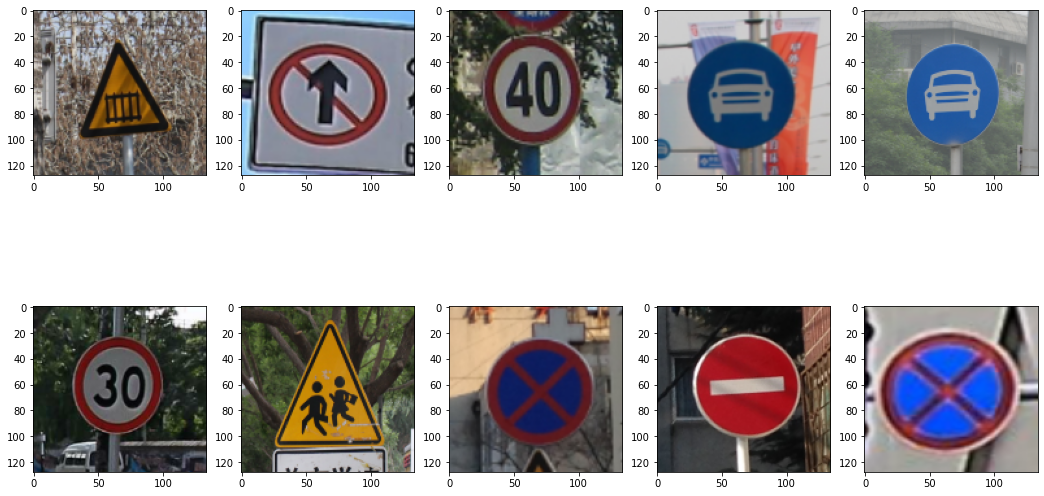

In [4]:
COLOR_LABEL = (255, 255, 255)
THICKNESS = 2
FONT_SCALE = 1
idxs_train = (27, 176, 1464, 3111, 1981)
idxs_valid = (19, 555, 101, 127, 454)
LENGTH = len(idxs_train)

imgs_train = []
imgs_valid = []

for i in range(LENGTH):
    imgs_train.append(train_X[idxs_train[i]])
    imgs_valid.append(valid_X[idxs_valid[i]])


# for i in range(LENGTH):
#     label_train = np.where(train_Y[idxs_train[i]] == 1)[0]
#     cv2.putText(imgs_train[i], str(label_train), (50, 50), 0, FONT_SCALE, COLOR_LABEL, THICKNESS//2)
#     label_valid = np.where(valid_Y[idxs_valid[i]] == 1)[0]
#     cv2.putText(imgs_valid[i], str(label_valid), (50, 50), 0, FONT_SCALE, COLOR_LABEL, THICKNESS//2)


for k in range(LENGTH):
    plt.subplot(2, LENGTH, k+1)
    plt.imshow(imgs_train[k])
    plt.subplot(2, LENGTH, k+LENGTH+1)
    plt.imshow(imgs_valid[k])

Ok we now define the CNN that we will use for training the model

In [5]:
def create_model(input_dims, num_classes):
    model = model = Sequential()
    
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_dims))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Conv2D(32, (5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(Flatten())  
    model.add(Dense(64, activation='relu',))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
     
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

CNN = create_model(X[0,:].shape, y.shape[1])

2021-10-07 11:57:11.001308: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-07 11:57:11.001361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: CPU00370U
2021-10-07 11:57:11.001373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: CPU00370U
2021-10-07 11:57:11.001497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.91.3
2021-10-07 11:57:11.001534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.91.3
2021-10-07 11:57:11.001543: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.91.3
2021-10-07 11:57:11.002040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Now we start training the model. We will do that for 30 epochs, and track the accuracy over each epoch. We apply several augmentations to the training set to enhance generalization.

In [6]:
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

MODEL_NAME = 'chinese_traffic_sign_classifier_v1.h5'
NUM_EPOCHS = 30
BATCH_SIZE = 100

checkpoint = ModelCheckpoint(MODEL_NAME, save_best_only=True, monitor='accuracy', mode='auto') 

h = CNN.fit(trainAug.flow(train_X, train_Y, batch_size=BATCH_SIZE), steps_per_epoch=len(train_X) // BATCH_SIZE,
    validation_data=(valid_X, valid_Y), validation_steps=len(valid_X) // BATCH_SIZE, callbacks=[checkpoint],
    epochs=NUM_EPOCHS)

2021-10-07 11:57:22.544085: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-10-07 11:57:23.256923: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206336000 exceeds 10% of free system memory.
2021-10-07 11:57:23.520757: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206336000 exceeds 10% of free system memory.


 1/33 [..............................] - ETA: 41s - loss: 4.1194 - accuracy: 0.0200

2021-10-07 11:57:23.878070: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206336000 exceeds 10% of free system memory.
2021-10-07 11:57:24.098755: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206336000 exceeds 10% of free system memory.


 3/33 [=>............................] - ETA: 11s - loss: 4.0450 - accuracy: 0.0424

2021-10-07 11:57:24.684171: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206336000 exceeds 10% of free system memory.


33/33 [==============================] - 19s 559ms/step - loss: 3.5547 - accuracy: 0.1610 - val_loss: 3.0560 - val_accuracy: 0.2734
Epoch 2/30
33/33 [==============================] - 18s 543ms/step - loss: 2.8861 - accuracy: 0.2599 - val_loss: 2.4529 - val_accuracy: 0.3585
Epoch 3/30
33/33 [==============================] - 19s 571ms/step - loss: 2.4420 - accuracy: 0.3477 - val_loss: 2.1265 - val_accuracy: 0.4281
Epoch 4/30
33/33 [==============================] - 19s 560ms/step - loss: 2.0711 - accuracy: 0.4360 - val_loss: 1.6714 - val_accuracy: 0.5647
Epoch 5/30
33/33 [==============================] - 17s 516ms/step - loss: 1.7243 - accuracy: 0.5198 - val_loss: 1.3392 - val_accuracy: 0.6619
Epoch 6/30
33/33 [==============================] - 17s 521ms/step - loss: 1.4543 - accuracy: 0.5998 - val_loss: 1.1256 - val_accuracy: 0.7242
Epoch 7/30
33/33 [==============================] - 17s 519ms/step - loss: 1.2354 - accuracy: 0.6514 - val_loss: 0.9266 - val_accuracy: 0.7890
Epoch 8/30

Let's plot the accuracy and loss over time

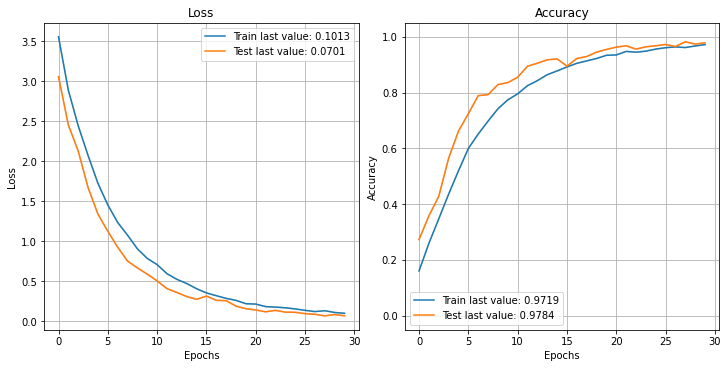

In [7]:
plot_history(h.history)
plt.show()

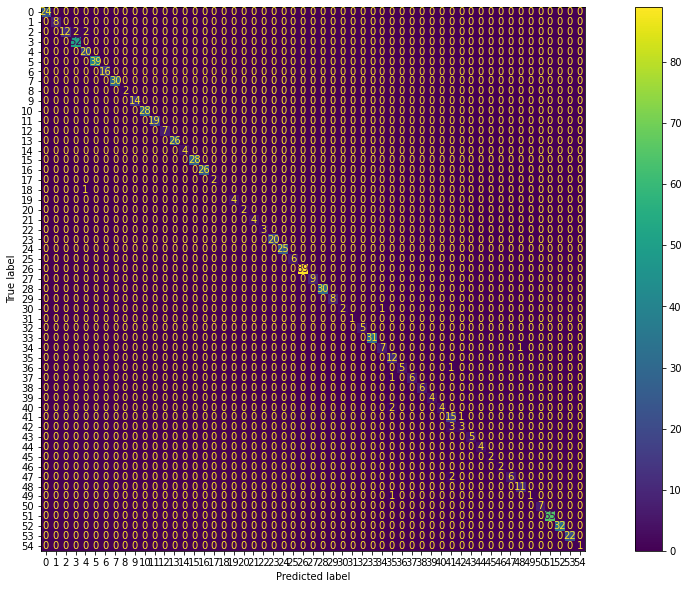

In [8]:
predIdxs = CNN.predict(valid_X, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

cm = confusion_matrix(valid_Y.argmax(axis=1), predIdxs)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)
plt.show()